#INFO and imports

**Moutning google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

#Loss and Metrics

**Loss**

Dice Loss

In [ ]:
def dice_coeff(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coeff(y_true, y_pred)


**Metrics**

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels

metrics = [dice_coeff,iou_coef,'binary_accuracy',pixel_accuracy]

**Optimizers**

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, ###
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

**callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback= [ModelCheckpoint('/content/drive/MyDrive/models/m2.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = 20, verbose =1, restore_best_weights=True ,monitor = "val_loss")]

#Model

In [ ]:
def unet(input_size = (256,256,1) , sart_neurons = 32):
    inputs = Input(input_size)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(sart_neurons * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [ ]:
model = unet()

In [ ]:
model.compile('adam', loss=dice_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 36.0 MB/s eta 0:00:00


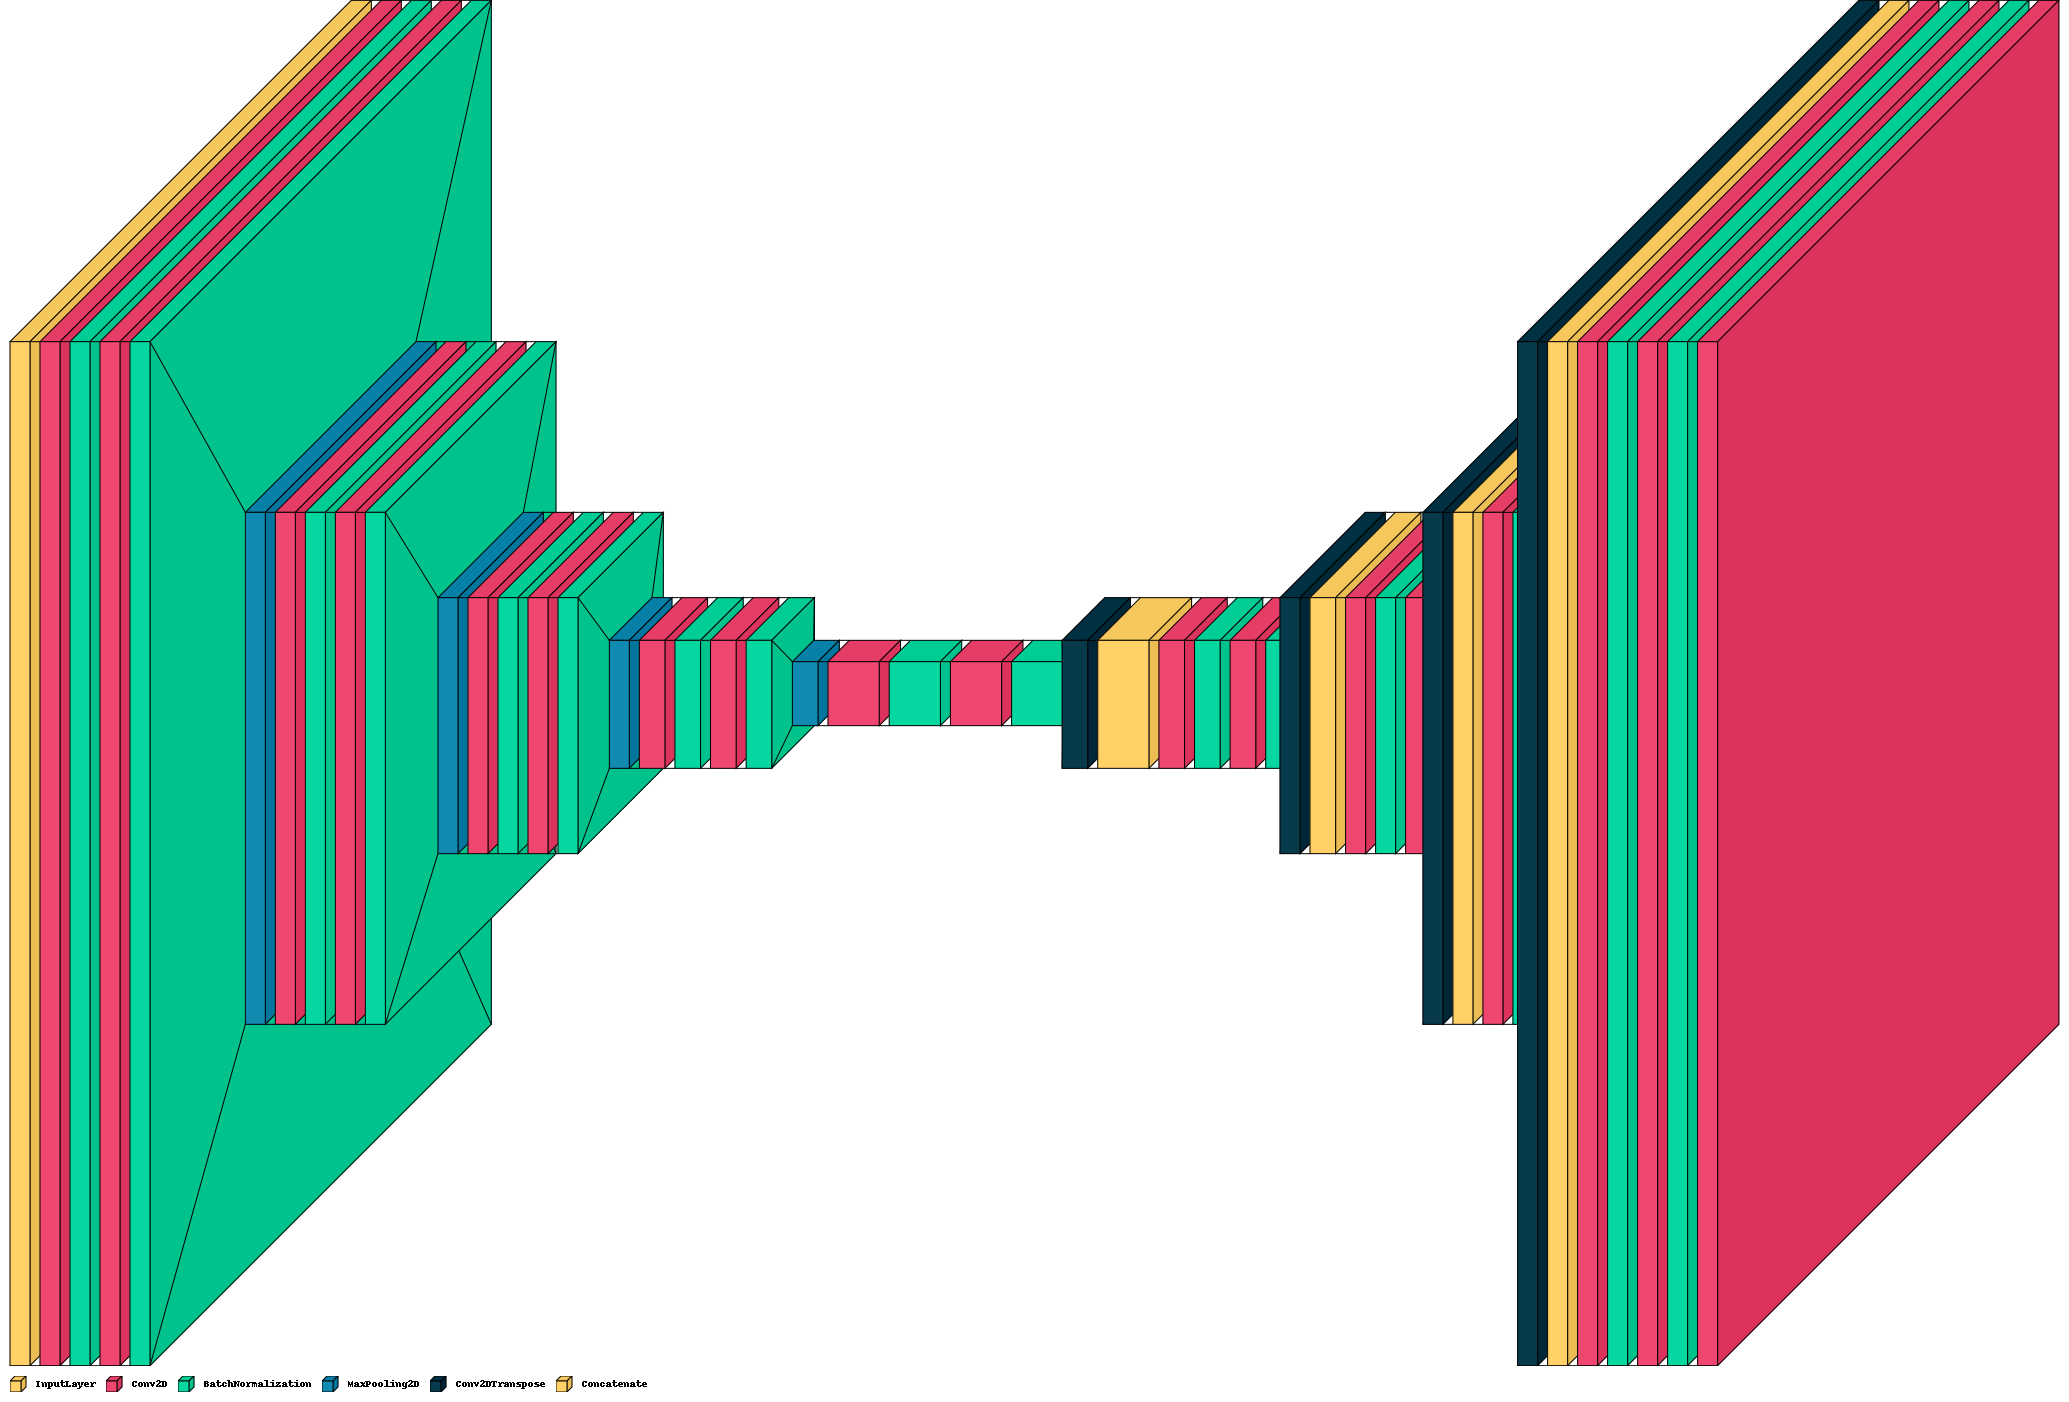

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

#**Fitting**

In [ ]:
from sklearn.model_selection import train_test_split

IMAGES_sub = np.split(IMAGES, 2)[0] ## remvoe this
MASKS_sub = np.split(MASKS, 2)[0] ## remove this


# Split dataset into train and test sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

# Split training set into train and validation sets (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

batch_size = 1 ##
train_steps = x_train.shape[0] // batch_size
test_steps = x_val.shape[0] // batch_size

model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          steps_per_epoch = train_steps, 
          validation_steps= test_steps ,
          shuffle=True,
          callbacks = callback,
          batch_size = batch_size, 
          validation_data=(x_val, y_val))

Epoch 1/100
1141/1141 [==============================] - ETA: 0s - loss: 0.8932 - dice_coeff: 0.1068 - iou_coef: 0.0285 - binary_accuracy: 0.9154 - pixel_accuracy: 0.9154
Epoch 1: val_loss improved from inf to 0.86257, saving model to /content/drive/MyDrive/models/m2.h5
1141/1141 [==============================] - 68s 35ms/step - loss: 0.8932 - dice_coeff: 0.1068 - iou_coef: 0.0285 - binary_accuracy: 0.9154 - pixel_accuracy: 0.9154 - val_loss: 0.8626 - val_dice_coeff: 0.1374 - val_iou_coef: 0.0284 - val_binary_accuracy: 0.9643 - val_pixel_accuracy: 0.9643
Epoch 2/100
1141/1141 [==============================] - ETA: 0s - loss: 0.8385 - dice_coeff: 0.1615 - iou_coef: 0.0387 - binary_accuracy: 0.9787 - pixel_accuracy: 0.9787
Epoch 2: val_loss did not improve from 0.86257
1141/1141 [==============================] - 35s 30ms/step - loss: 0.8385 - dice_coeff: 0.1615 - iou_coef: 0.0387 - binary_accuracy: 0.9787 - pixel_accuracy: 0.9787 - val_loss: 0.8824 - val_dice_coeff: 0.1176 - val_iou_c

**ploting samples of the predectied**

In [ ]:
from matplotlib import pyplot as plt

def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

In [ ]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/models/m2.h5')

In [ ]:
predicted = saved_model.predict(x_test)

In [ ]:
plot_image(predicted[2])
plot_image(x_test[2])
plot_image(y_test[2])